In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
import matplotlib.pyplot as plt

In [36]:
# 1. Data Acquisition and Preprocessing
def get_pair_data(ticker1, ticker2, start_date, end_date):
    df1 = yf.download(ticker1, start=start_date, end=end_date)['Adj Close']
    df2 = yf.download(ticker2, start=start_date, end=end_date)['Adj Close']
    df = pd.DataFrame({'Asset1': df1, 'Asset2': df2})

    # Calculate the spread (e.g., price ratio or difference)
    df['Spread'] = df['Asset1'] / df['Asset2']  # Example: price ratio
    return df

ticker1 = "AAPL"  # Example: Apple
ticker2 = "MSFT"  # Example: Microsoft
start_date = "2020-01-01"
end_date = "2023-10-26"

df = get_pair_data(ticker1, ticker2, start_date, end_date)
snp500 = yf.download("^GSPC", start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Users\magal\anaconda3\envs\new_base\lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\magal\anaconda3\envs\new_base\lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed


C:\Users\magal\anaconda3\envs\new_base\lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [37]:
# 2. Stationarity Check
def check_stationarity(series): #Check if stationary with Augmented Dickey-Fuller
    result = adfuller(series)
    p_value = result[1]
    return p_value < 0.05  # Reject null if p < 0.05

if not check_stationarity(df['Spread']):
    print("Spread is not stationary. Consider cointegration or transformations.")
    # Example transformation (if needed): differencing
    df['Spread_Diff'] = df['Spread'].diff() # First difference
    df = df.dropna()
    if check_stationarity(df['Spread_Diff']):
        print("Differenced spread is stationary.")
        df['Spread'] = df['Spread_Diff']  # Use the differenced spread
    else:
        raise ValueError("Spread (even differenced) is not stationary.  Pairs trading might not be suitable.")

Spread is not stationary. Consider cointegration or transformations.
Differenced spread is stationary.


In [38]:
# 3. Feature Engineering (using a simple moving average of the spread)
#df['SMA_Spread'] = df['Spread'].rolling(window=20).mean() # Example: 20-day SMA
df['Previous_Spread'] = df['Spread'].shift(1)

# 4. Machine Learning Model (Linear Regression for demonstration)
# Create features (X) and target (y)
df['Target'] = df['Spread'].shift(-1)  # Predict the next day's spread
df.dropna(inplace=True)  # Remove rows with NaN from shifting

X = df[['Spread', 'Previous_Spread']] # Features
y = df['Target']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) # Important: Don't shuffle time series data

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [39]:
predict_test = model.predict(X_test)
mean_squared_error(predict_test,y_test)

6.42989007121414e-05

In [40]:
# 5. Backtesting (Simplified Example)
df['Predicted_Spread'] = model.predict(X)

# Trading Logic (Example - very basic)
position = 0  # 0: No position, 1: Long pair, -1: Short pair
capital = 10000
shares1 = 0
shares2 = 0
portfolio = 0
df['Total'] = capital
for i in range(1, len(df)):
    spread = df['Spread'].iloc[i]
    predicted_spread = df['Predicted_Spread'].iloc[i]
    #sma_spread = df['SMA_Spread'].iloc[i]

    if spread > predicted_spread and position == 0: # Spread above SMA and no position
      position = -1 # Short the pair (sell asset1, buy asset2)
      # Calculate number of shares to trade (simplified)
      dshares1 = -int(capital*0.5 / df["Asset1"].iloc[i])
      dshares2 = int(capital*0.5 / df["Asset2"].iloc[i])
      capital -= dshares1 * df["Asset1"].iloc[i]
      capital -= dshares2 * df["Asset2"].iloc[i]
      shares1 += dshares1
      shares2 += dshares2
      portfolio = shares1*df["Asset1"].iloc[i]+shares2*df["Asset2"].iloc[i]
      print(f"Short Pair at {df.index[i]}: Spread={spread}, Shares1={shares1}, Shares2={shares2}, Capital={capital}, Portfolio={portfolio}")

    elif spread < predicted_spread and position == 0: # Spread below SMA and no position
      position = 1 # Long the pair (buy asset1, sell asset2)
      dshares1 = int(capital*0.5 / df["Asset1"].iloc[i])
      dshares2 = -int(capital*0.5 / df["Asset2"].iloc[i]) 
      capital -= dshares1 * df["Asset1"].iloc[i]
      capital -= dshares2 * df["Asset2"].iloc[i]
      shares1 += dshares1
      shares2 += dshares2
      portfolio = shares1*df["Asset1"].iloc[i]+shares2*df["Asset2"].iloc[i]
      print(f"Long Pair at {df.index[i]}: Spread={spread}, Shares1={shares1}, Shares2={shares2}, Capital={capital}, Portfolio={portfolio}")

    elif (spread < predicted_spread and position == -1) or (spread > predicted_spread and position == 1): # Spread crosses SMA and in position
      position = 0 # Close position
      capital += shares1 * df["Asset1"].iloc[i]
      capital += shares2 * df["Asset2"].iloc[i]
      shares1 = 0
      shares2 = 0
      portfolio = shares1*df["Asset1"].iloc[i]+shares2*df["Asset2"].iloc[i]
      print(f"Close Pair at {df.index[i]}: Spread={spread}, Capital={capital}, Portfolio={portfolio}")

    df.loc[df.index[i],'Total'] = capital+portfolio

print(f"Final Capital: {capital}")

# 6. Evaluation (Important: More robust metrics are needed)
# ... (Calculate metrics like Sharpe Ratio, Maximum Drawdown, etc.)

Short Pair at 2020-01-07 00:00:00: Spread=0.0021283143328269527, Shares1=-69, Shares2=33, Capital=10016.289154052734, Portfolio=-16.289154052734375
Close Pair at 2020-01-08 00:00:00: Spread=7.452979573824292e-05, Capital=9998.953094482422, Portfolio=0.0
Short Pair at 2020-01-09 00:00:00: Spread=0.004146375086962251, Shares1=-66, Shares2=32, Capital=9990.762771606445, Portfolio=8.190322875976562
Close Pair at 2020-01-14 00:00:00: Spread=-0.0032003075525905422, Capital=9951.388702392578, Portfolio=0.0
Long Pair at 2020-01-15 00:00:00: Spread=-0.005225381433781262, Shares1=65, Shares2=-31, Capital=9884.967887878418, Portfolio=66.42081451416016
Close Pair at 2020-01-17 00:00:00: Spread=0.002616835601911227, Capital=9951.578216552734, Portfolio=0.0
Long Pair at 2020-01-21 00:00:00: Spread=-0.0015454614661349342, Shares1=64, Shares2=-31, Capital=9977.93229675293, Portfolio=-26.354080200195312
Close Pair at 2020-01-22 00:00:00: Spread=0.004054126421724147, Capital=9992.827209472656, Portfolio

C:\Users\magal\AppData\Local\Temp\ipykernel_22336\2325398312.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9998.953094482422' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.index[i],'Total'] = capital+portfolio


Close Pair at 2021-09-30 00:00:00: Spread=-0.0010169410622795638, Capital=11092.534534454346, Portfolio=0.0
Long Pair at 2021-10-01 00:00:00: Spread=-0.008570608780419875, Shares1=39, Shares2=-19, Capital=10971.090686798096, Portfolio=121.44384765625
Close Pair at 2021-10-07 00:00:00: Spread=0.0015306520741800722, Capital=11010.76134109497, Portfolio=0.0
Long Pair at 2021-10-08 00:00:00: Spread=-0.0013355555536643249, Shares1=39, Shares2=-19, Capital=10986.032871246338, Portfolio=24.728469848632812
Close Pair at 2021-10-11 00:00:00: Spread=0.0007225403936297892, Capital=11018.776111602783, Portfolio=0.0
Long Pair at 2021-10-12 00:00:00: Spread=-0.0022229495345318373, Shares1=39, Shares2=-19, Capital=11010.887271881104, Portfolio=7.8888397216796875
Close Pair at 2021-10-15 00:00:00: Spread=0.0012835610861750002, Capital=10936.921085357666, Portfolio=0.0
Short Pair at 2021-10-18 00:00:00: Spread=0.0008002220264207716, Shares1=-37, Shares2=18, Capital=10882.555698394775, Portfolio=54.3653

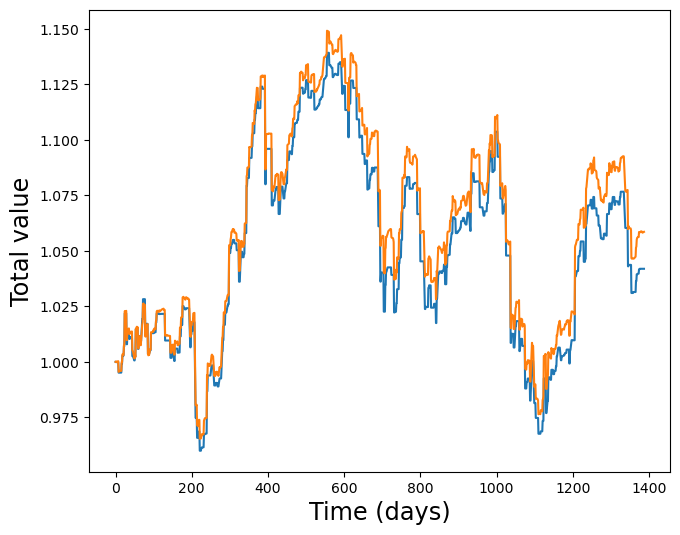

In [41]:
#Plot resulting total value (capital+portfolio) and compare to S&P 500
fig, ax = plt.subplots(1,1,figsize=(7.5,6))

ax.set_ylabel('Total value',fontsize='xx-large')
ax.set_xlabel('Time (days)',fontsize='xx-large')

ax.plot((df.index-df.index[0]).days,df['Total']/df['Total'].iloc[0])
ax.plot((df.index-df.index[0]).days,(df['Total']+df['Asset2'])/(df['Total']+df['Asset2']).iloc[0])
#ax.plot((snp500.index-snp500.index[0]).days,snp500/snp500.iloc[0])

In [19]:
# Calculate relevant trading metrics (assuming daily risk free rate of 0 for simplicity)
df['returns'] = df['Total'].pct_change()
sharpe_ratio = np.sqrt(252)*df['returns'].mean()/df['returns'].std()
df['Peak'] = df['Total'].cummax()
df['Drawdown'] = (df['Peak']-df['Total'])/df['Peak']
max_drawdown = df['Drawdown'].max()

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Maximum Drawdown: {max_drawdown}")

snp_sharpe = np.sqrt(252)*(snp500/snp500.iloc[0]).pct_change().mean()/(snp500/snp500.iloc[0]).pct_change().std()
print(f"S&P500 Sharpe Ratio: {snp_sharpe}")

Sharpe Ratio: 0.42249630486852735
Maximum Drawdown: 0.18426369783116708
S&P500 Sharpe Ratio: 0.39889936832790696


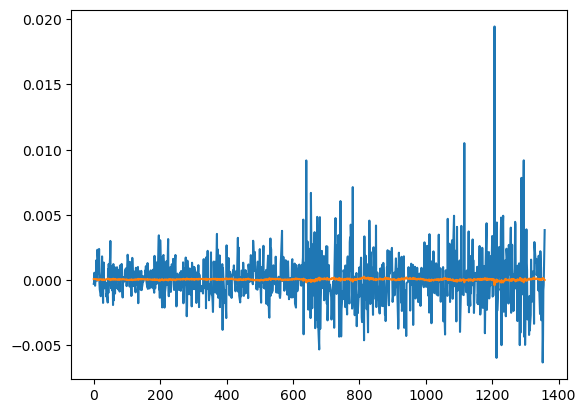

In [33]:
plt.plot((df.index-df.index[0]).days,df['Spread'])
plt.plot((df.index-df.index[0]).days,df['Predicted_Spread'])